# Clothing Data

For this assignment, you will work with data from a popular clothing website, modcloth.com. This
gives us a chance to work with feature engineering, feature extraction, and unbalanced,
multiclass datasets. You will train several different classification models based on different types
of data from this dataset.

As you go through the assignment, you will create several tables and figures. After you
complete the programming section, use the tables and figures you generated to answer the questions.


In [67]:
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
import json
import sklearn
import matplotlib.pyplot as plt
# This ensures that sklearn 0.24 is loaded on Google colab
!pip uninstall scikit-learn -y
!pip install -U scikit-learn

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, StandardScaler, Normalizer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import Perceptron

Found existing installation: scikit-learn 1.7.0
Uninstalling scikit-learn-1.7.0:
  Successfully uninstalled scikit-learn-1.7.0
  Using cached scikit_learn-1.7.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (17 kB)
Using cached scikit_learn-1.7.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.9 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.0 which is incompatible.


# Pre-Processing and Loading Data:

The Blackboard assignment prompt contains the modcloth_final_data.json file, which is a series of
JSON objects from a popular clothing store, modcloth.com. Load these objects into a list, and
then use pd.DataFrame to convert that list into a dataframe called modcloth_data.


In [52]:
file_id = '1ZyKY8UY1-Vbr-ol2CP8dKGUs5LH0cTZ3'  # Replace with your file's ID
!gdown --id $file_id -O /content/modcloth_final_data.json
df = pd.read_json('/content/modcloth_final_data.json', lines=True)


/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1ZyKY8UY1-Vbr-ol2CP8dKGUs5LH0cTZ3
To: /content/modcloth_final_data.json
100% 40.6M/40.6M [00:00<00:00, 116MB/s]


In [53]:
df.head()

modcloth = pd.DataFrame(df)
# remove rows with null quality values
modcloth = modcloth[modcloth['quality'].notna()]
# remove bust outlier
#modcloth = modcloth[modcloth['bust'] != '37-39']

modcloth.head()

,item_id,waist,size,quality,cup size,hips,bra size,category,bust,height,user_name,length,fit,user_id,shoe size,shoe width,review_summary,review_text
0,123373,29.0,7,5.0,d,38.0,34.0,new,36,5ft 6in,Emily,just right,small,991571,NaN,NaN,NaN,NaN
1,123373,31.0,13,3.0,b,30.0,36.0,new,NaN,5ft 2in,sydneybraden2001,just right,small,587883,NaN,NaN,NaN,NaN
2,123373,30.0,7,2.0,b,NaN,32.0,new,NaN,5ft 7in,Ugggh,slightly long,small,395665,9.0,NaN,NaN,NaN
3,123373,NaN,21,5.0,dd/e,NaN,NaN,new,NaN,NaN,alexmeyer626,just right,fit,875643,NaN,NaN,NaN,NaN
4,123373,NaN,18,5.0,b,NaN,36.0,new,NaN,5ft 2in,dberrones1,slightly long,small,944840,NaN,NaN,NaN,NaN


In [54]:
modcloth.describe()

,item_id,waist,size,quality,hips,bra size,user_id,shoe size
count,82722.000000,2843.000000,82722.000000,82722.000000,56031.000000,76723.000000,82722.000000,27886.000000
mean,469317.322756,31.325009,12.661577,3.949058,40.358159,35.972238,498814.293900,8.146131
std,213996.309012,5.290628,8.271299,0.992783,5.827107,3.224523,286379.344825,1.336211
min,123373.000000,20.000000,0.000000,1.000000,30.000000,28.000000,6.000000,5.000000
25%,314980.000000,28.000000,8.000000,3.000000,36.000000,34.000000,252860.000000,7.000000
50%,454030.000000,30.000000,12.000000,4.000000,39.000000,36.000000,497768.000000,8.000000
75%,658440.000000,34.000000,15.000000,5.000000,43.000000,38.000000,744745.250000,9.000000
max,807722.000000,50.000000,38.000000,5.000000,60.000000,48.000000,999972.000000,38.000000


In [55]:
modcloth.isna().sum()

,0
item_id,0
waist,79879
size,0
quality,0
cup size,6231
hips,26691
bra size,5999
category,0
bust,70889
height,1103


Create a variable named ‘labels’ using the ‘quality’ column. These are the labels that we will use
for the rest of this assignment.

Next, you will transform these data into numerical vectors you can use for classification.
For the variables ‘waist’, ’size’, ’hips’, ‘bra size’, and ‘shoe size’ you can use
pd.to_numeric(modcloth_data[variable] to convert them to numerical values. Store
these in a data frame.


For the next variable, ‘height’, the strings need some processing to convert them into numeric
values. You can use pd.apply to apply a transformation to the column of the data frame. Write a
short python function to convert these to a meaningful categorical variable: convert the strings to
height (in inches).

Also, do this for the variable ‘bust’ - there are some outliers that could be handled by writing and applying another python function. Convert height and bust and store the
numeric values to the same data frame as the other numeric features.


In [56]:
# create variable named 'labels' using the 'quality column'
labels = modcloth['quality']

In [57]:
# Transform column to numerical vectors

num_waist = pd.to_numeric(modcloth['waist'])
num_size = pd.to_numeric(modcloth['size'])
num_hips = pd.to_numeric(modcloth['hips'])
num_bra = pd.to_numeric(modcloth['bra size'])
num_shoe = pd.to_numeric(modcloth['shoe size'])

# Store in data frame
data = {
    'num_waist': num_waist,
    'num_size': num_size,
    'num_hips': num_hips,
    'num_bra': num_bra,
    'num_shoe': num_shoe
}


num_df = pd.DataFrame(data)

# Display
num_df.head()

,num_waist,num_size,num_hips,num_bra,num_shoe
0,29.0,7,38.0,34.0,NaN
1,31.0,13,30.0,36.0,NaN
2,30.0,7,NaN,32.0,9.0
3,NaN,21,NaN,NaN,NaN
4,NaN,18,NaN,36.0,NaN


In [61]:
# Convert height to inches

# Get the first character of each string in 'height'
df['ht_first_char'] = df['height'].str[0]

In [62]:
# Convert height in feet field to numeric
num_ht_ft = pd.to_numeric(df['ht_first_char'], errors='coerce')

# # Multiply feet by 12 inches to convert to inches
df['num_ht_ft'] = num_ht_ft*12

In [63]:
# Step 2. Get inches character. Remember Python numbering starts at 0.
df['ht_fourth_char'] = df['height'].str[4]

# Convert height in inches field to numeric
num_ht_in = pd.to_numeric(df['ht_fourth_char'], errors='coerce')

In [64]:
# Add num_ht_in as column
df['num_ht_in'] = num_ht_in

# Add the feet in inches and inches columns
df['height'] = df['num_ht_ft'] + df['num_ht_in']

df.head()

,item_id,waist,size,quality,cup size,hips,bra size,category,bust,height,...,fit,user_id,shoe size,shoe width,review_summary,review_text,ht_first_char,ht_fourth_char,num_ht_in,num_ht_ft
0,123373,29.0,7,5.0,d,38.0,34.0,new,36,66.0,...,small,991571,NaN,NaN,NaN,NaN,5,6,6.0,60.0
1,123373,31.0,13,3.0,b,30.0,36.0,new,NaN,62.0,...,small,587883,NaN,NaN,NaN,NaN,5,2,2.0,60.0
2,123373,30.0,7,2.0,b,NaN,32.0,new,NaN,67.0,...,small,395665,9.0,NaN,NaN,NaN,5,7,7.0,60.0
3,123373,NaN,21,5.0,dd/e,NaN,NaN,new,NaN,NaN,...,fit,875643,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,123373,NaN,18,5.0,b,NaN,36.0,new,NaN,62.0,...,small,944840,NaN,NaN,NaN,NaN,5,2,2.0,60.0


In [65]:
# labels = modcloth['quality']
# # Convert waist, size, hips, bra size, shoe size to numeric:
# num_cols =
# # store to dataframe
# num_df = pd.DataFrame()
# num_df[num_cols] = modcloth[num_cols].apply(pd.to_numeric, errors='coerce')
# # Convert height
# num_df['height (inch)'] = modcloth['height'].apply(conv_height)

# Convert bust
num_df['bust (inch)'] = pd.to_numeric(df['bust'], errors='coerce')

In [74]:
# Save height and bust columns to num_df dataframe
# Add column 'B' from df2 to df1
num_df['height'] = df['height']
# num_df['bust (inch)'] = df['bust (inch)']

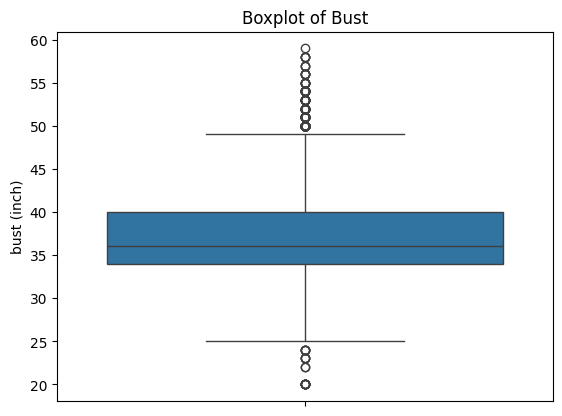

In [75]:
# Create boxplot to visualize outliers
sns.boxplot(num_df['bust (inch)'])
plt.title('Boxplot of Bust')
plt.show()

# Detect and remove the outliers using Python. GeeksforGeeks. (2025, June 13). https://www.geeksforgeeks.org/data-science/detect-and-remove-the-outliers-using-python/

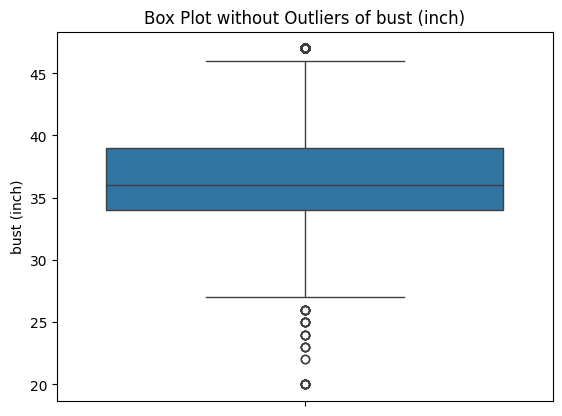

In [76]:
# Remove outliers
def removal_box_plot(num_df, column, threshold):
    removed_outliers = num_df[num_df[column] <= threshold]

    sns.boxplot(removed_outliers[column])
    plt.title(f'Box Plot without Outliers of {column}')
    plt.show()
    return removed_outliers


threshold_value = 47

no_outliers = removal_box_plot(num_df, 'bust (inch)', threshold_value)

# Detect and remove the outliers using Python. GeeksforGeeks. (2025, June 13). https://www.geeksforgeeks.org/data-science/detect-and-remove-the-outliers-using-python/

In [ ]:
# Feel free to have you own function(s). Here is a suggestion for you to get an idea

# def conv_height(x):
#     if pd.isnull(x):
#         return x
#     spt = x.split(' ')
#     ft = int(spt[0].split('ft')[0])
#     inch = 0
#     if len(spt) > 1:
#         inch = int(spt[1].split('in')[0])
#     return (ft * 12) + inch
# def conv_bust(x):
#     if pd.isnull(x):
#         return x
#     spt = x.split('-')
#     # if range, split the difference
#     if len(spt) > 1:
#         return (int(spt[1]) - int(spt[0]) // 2) + int(spt[0])
#     return int(spt[0])

Plot the height using seaborn’s distplot function. You should see a normal distribution of height,
which should match your expectations for what the distribution of human heights should look
like.


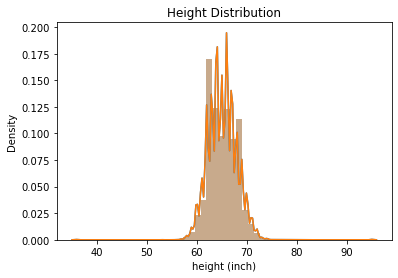

In [ ]:
sns.distplot(df['height'])
sns.distplot(num_df['height (inch)'])
plt.title('Height Distribution')
plt.show();

In [ ]:
#Plot 'bust (inch)' here

Make a plot of the waist data, which should look like this:


In [ ]:
#Plot here

# Categorical Data for Reviews

For these values, ‘cup size’, ‘length’, ‘category’, use OneHotEncoder to convert these to a data
frame called cat_feat.
Use make_pipeline to compare these two classifiers:



```
balanced_model = make_pipeline(,Perceptronclass_weight='balanced'))
unbalanced_model = make_pipeline(,Perceptron())
```




Train a classifier using the data in cat_feat. Use train_test_split and test_size=0.50 to get a
50/50 train and test split.
Use metrics.plot_confusion_matrix and metrics.classification_report to report and visualize the
confusion matrix and results. Perform this for both the balanced and unbalanced models.

In [ ]:
# one-hot encode
# cat_feat = modcloth[[...]]
# train_test_split here

balanced_model = make_pipeline(OneHotEncoder(),Perceptron(class_weight='balanced'))
unbalanced_model = make_pipeline(OneHotEncoder(), Perceptron())

# fit the models here:

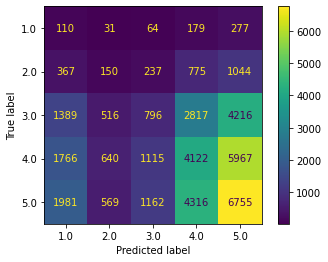

In [ ]:
#Plot Balanced here

In [ ]:
#print classification_report balanced here

In [ ]:
#Plot unBalanced here

In [ ]:
#print classification_report Unbalanced here

              precision    recall  f1-score   support

         1.0       0.06      0.02      0.03       661
         2.0       0.05      0.02      0.03      2573
         3.0       0.24      0.14      0.17      9734
         4.0       0.33      0.35      0.34     13610
         5.0       0.37      0.51      0.43     14783

    accuracy                           0.33     41361
   macro avg       0.21      0.21      0.20     41361
weighted avg       0.30      0.33      0.31     41361



# Categorical and Numeric Features
Next, you will add in data from the numeric features. Unfortunately, many of these values are
missing: not every JSON object will have a value for this numeric value.


In [ ]:
comb_df = pd.merge(cat_feat, num_df[num_df.index.isin(cat_feat.index)],left_index=True, right_index=True)
#train_test_split here

categorical = ['cup size', 'length', 'category']
numerical = ['waist', 'size', 'hips', 'bra size', 'shoe size', 'height (inch)','bust (inch)']

# Pipelines


You will use imputation
as implemented in https://scikit-learn.org/stable/modules/impute.html to fill in the missing values
before classification: **use SimpleImputer.**


Next, you will create three pipelines. Create one pipeline using SimpleImputer to impute the missing
values and the balanced perceptron.


Next, create a pipeline using **preprocessing.Normalizer()**.

Finally, create a different pipeline using preprocessing.**StandardScaler()**.

For each of the pipeline,l do fivefold cross-validation, using
**scores = cross_val_score(model, X, y, cv=5,scoring=’accuracy’)**

to compute the accuracy of each of the pipelines.
Create a table, with a row (labeled) for each pipeline you created.


In [ ]:
# Categorical pipeline
cat_pipe = Pipeline([('encoder', OneHotEncoder(handle_unknown='ignore',sparse=False))])

# Simple Imputer pipeline
impute_pipe = Pipeline([('imputer', SimpleImputer(missing_values=np.nan,strategy='median'))])
impute_model = make_pipeline(ColumnTransformer([('cat', cat_pipe, categorical),('num', impute_pipe, numerical)]),Perceptron(class_weight='balanced'))

# Normalize pipeline:


# Standardize pipeline:

In [ ]:
#impute_scores =
#norm_scores =
#std_scores =

# Model Accuracy


The table should report the
*maximum*, *minimum*, and *mean* of accuracy for each of the pipelines.

In [ ]:
#all_scores =

# pd.DataFrame(all_scores)

# Text Data from Reviews

Finally, you will use the words in the consumer reviews to build a classifier to predict the results.
*corpus = modcloth_data['review_text']*

Create a new variable from the text data, after removing outliers, which are records that contain
no text data (these will be nans in your data frame). This new variable is a list of strings, where
every string is a consumer review.



In [ ]:
#corpus = modcloth['review_text']

# Remove Outliers (records with no text data nans):

#corpus.describe()

**TfidfVectorizer**

Pass this new variable to sklearn’sTfidfVectorizer
(https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction) to load
the data. Create a new dataframe called X from the bag of words features, using
*pd.DataFrame.sparse.from_spmatrix*, and subset the labels to only those which have text data
present.



**Feature Selection - Top 10**

Next, use feature selection
(https://scikit-learn.org/stable/modules/feature_selection.html#feature-selection) to subset the
text data to only the most relevant features. Be sure to do this based on the training set, then
apply the transformation to the test set. Using the pipeline can make this step easier.

Use *SelectKBest* and *chi-2* to select features. Make sure you have the latest version (at least
0.24 of scikit-learn, or you may get errors).

Print a list of the top ten features selected. Hint: Use
*vectorizer.get_feature_names(), XKBest.fit()* and then *XNew.get_support()*.




In [ ]:
# Check out the shared link for the "TfidfVectorizer" and review 6.2.3.3. Common Vectorizer usage
# Use the function here
#spmat = fit_transform here
#feat_names = get_feature_names here

#X = pd.DataFrame.sparse.from_spmatrix(spmat, columns=feat_names)
#train_test_split here

In [ ]:
# Check out the shared link about FS and review 1.13.2. Univariate feature selection

#print('Top 10 features %s' % Xtrain.columns[kbest.get_support()].tolist())

**Accuracy**

For k in the range [10,25,50,100,250,500,1000,10000], plot the accuracy of the
classifier for each value of k.

In [ ]:
k_vals = [10,25,50,100,250,500,1000,10000]
results = []
for k in k_vals:

    # print('Top 10 features at k=%d %s' % (k, Xtrain.columns[kbest.get_support()].tolist()))
    # X_new has k best features:


    # Test Accuracy using kbest features from training:

    results.append({'k-value': k, 'Training Accuracy': train_acc, 'Test Accuracy':test_acc})

In [ ]:
results_df = pd.DataFrame(results)
results_df

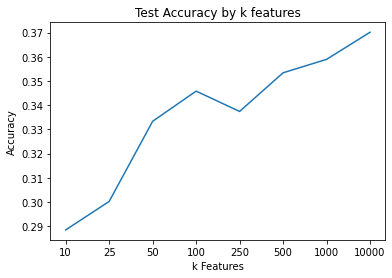

In [ ]:
#Plot it here